In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [18]:
import scipy.optimize
import scipy.sparse

### Problem 1

#### Part (a). Figure out a relation between $x^* = argmin_{x \in C}(||x-z||_2^2$ (1) and $x'^* = argmin_x{x \in C}(-z^T x + ||x||_2^2/2)$ (2)

By definition of argmin $\forall x \in C ||x-z||_2^2 \geq ||x^*-z||_2^2$ so $x^T x - 2 x^T z + z^T z \geq {x^*}^T x^* - 2 z^T x^* + z^T z$ which is equal to $||x||_2^2 / 2 - z^T x \geq ||x^*||_2^2 / 2 - z^T x^*$ so $x^* = x'^*$ because it is argmin for (2). So the problems (1) and (2) have same solution always.

In [6]:
# implementation

N = 150
m = 10
A = np.random.normal(size=(N, m))

def f_i(i, x):
    return max(1 - A[i].T.dot(x), 0)

def f(x):
    return sum(f_i(i, x) for i in range(N)) / N

def num_zero_entries(x):
    return sum(1 for i in range(N) if f_i(i, x) == 0)

def num_nonzero_entries(x):
    return N - num_zero_entries(x)

def compute_g_k(x):
    i = np.random.randint(N)
    return -A[i]

def argmin_constrained(fun, x0):
    r = scipy.optimize.minimize(fun=fun,
                                x0=x0,
                                constraints=[
                                    {'type':'eq', 'fun':lambda x: np.sum(x) - 1},
                                    {'type':'ineq', 'fun':lambda x: x}
                                ])
    x = np.where(r.x > 1e-5, r.x, 0)
    return x
    

def next_pSGD(x_k, nu_k, g_k):
    z = x_k - nu_k * g_k
    # compute projection on C
    return argmin_constrained(
        fun=lambda x: np.linalg.norm(x-z)**2,
        x0=x_k
    )

def next_pDA(x_k, nu_k, theta_k):
    return argmin_constrained(
        fun=lambda x: theta_k.dot(x) + np.linalg.norm(x)**2 / 2 / nu_k,
        x0=x_k
    )

SS_CONST_VAL = 'const_val'
SS_CONST_LEN = 'const_len'
SS_ROOT_NK = 'root_nk'
SS_ROOT_K = 'root_k'
SUPPORTED_STEP_POLICIES = [SS_CONST_VAL, SS_CONST_LEN, SS_ROOT_NK, SS_ROOT_K]

def get_nu_k(k, g_k=None, method=SS_CONST_VAL, value=5):
    assert method in SUPPORTED_STEP_POLICIES
    if method == SS_CONST_VAL:
        return value
    elif method == SS_CONST_LEN:
        assert g_k is not None
        return value / np.linalg.norm(g_k)
    elif method == SS_ROOT_NK:
        return value / np.sqrt(N*k)
    elif method == SS_ROOT_K:
        return value / np.sqrt(k)
    raise ValueError(f"method {method} not supported")

def solve(x_0, method='pSGD', step_policy=SS_CONST_VAL, maxiter=100):
    x_k = x_0
    x_k_all = [x_0]
    g_k_all = [compute_g_k(x_0)]
    theta_k = g_k_all[-1]
    f_best = f(x_0)
    f_best_all = [f_best]
    f_all = [f_best]
    
    x_best = x_0
    for k in range(1, maxiter+1):
        x_k = np.copy(x_k_all[-1])
        g_k = np.copy(g_k_all[-1])
        nu_k = get_nu_k(k, g_k=g_k, method=step_policy)
        
        if method == 'pSGD':
            x_next = next_pSGD(x_k, nu_k, g_k)
        elif method == 'pDA':
            x_next = next_pDA(x_k, nu_k, theta_k)
            theta_k += g_k
        else:
            raise ValueError(f"unknown method {method}")
        g_next = compute_g_k(x_next)
        f_next = f(x_next)
        
        x_k_all.append(x_next)
        g_k_all.append(g_next)
        f_all.append(f_next)
        
        f_best = min(f_best, f_next)
        if f_best == f_next:
            x_best = x_0
        f_best_all.append(f_best)
    return f_best, x_best, (x_k_all, g_k_all, f_all, f_best_all)

#### Part (b). Consider different step-size policies, including $1/\sqrt{nk}$ for SGD and $1/\sqrt{k}$ for Dual averaging.  Show on plots how the gap $f(x_k)−f^∗$ decreases with the number of iterations.

#### Part (d). run your methods for m= 10, 50, and 100.  Set N= 150.

In [9]:
def plot_graphs(maxiter=1000):
    x0 = np.random.normal(size=(m,))
    for method in ['pSGD', 'pDA']:
        plt.figure(figsize=(15,10))
        best_f_best = 10000
        for step_policy in SUPPORTED_STEP_POLICIES:
            f_best, x_best, (x_k_all, g_k_all, f_all, f_best_all) = solve(
                x0, 
                method=method, 
                step_policy=step_policy, 
                maxiter=maxiter
            )
            best_f_best = min(best_f_best, f_best)
            plt.plot(f_best_all, label=step_policy)
        plt.ylim((best_f_best, 1.1))
        plt.xlabel("number of iterations")
        plt.ylabel("f_best")
        plt.title(f"Convergence of {method} with different step policies, N={N}, m={m}")
        plt.legend(loc='best')
        plt.show()

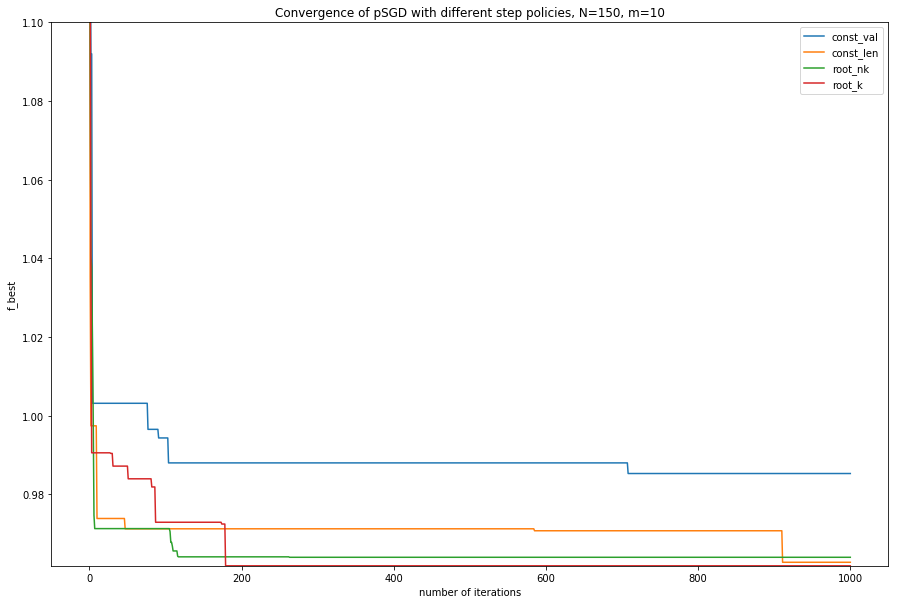

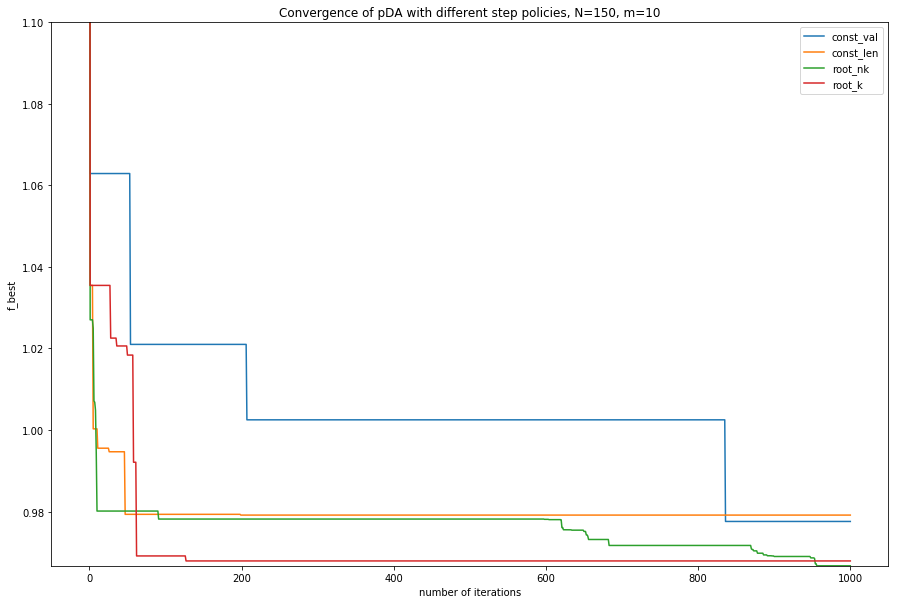

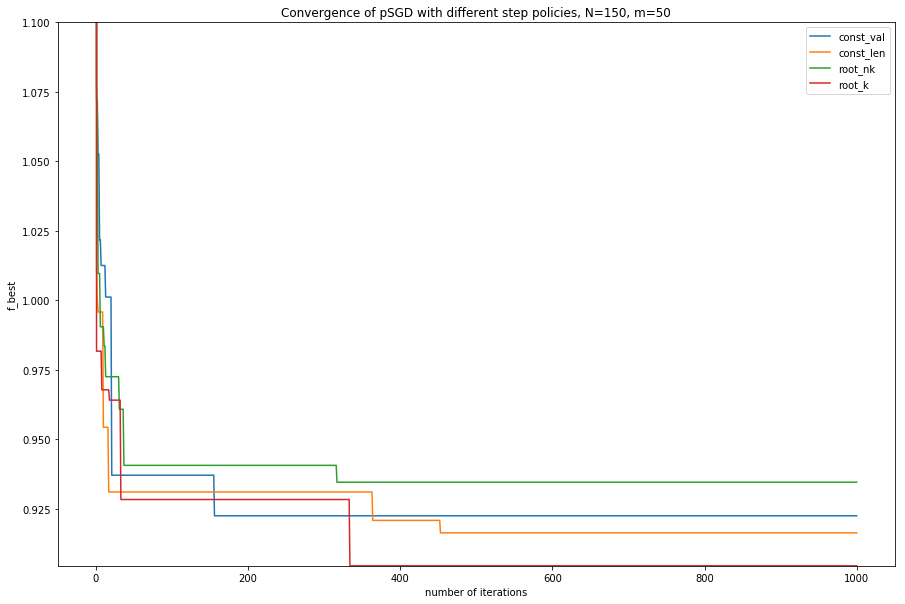

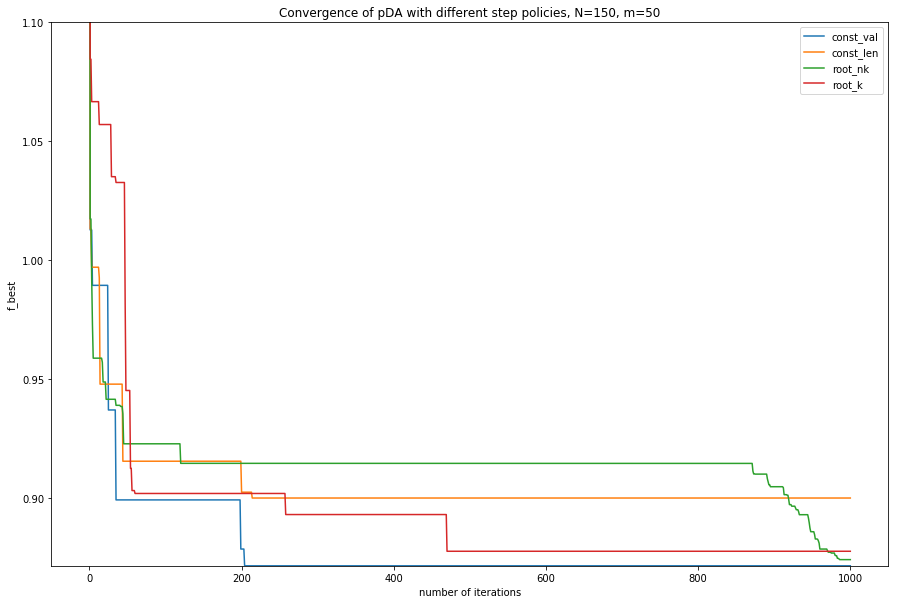

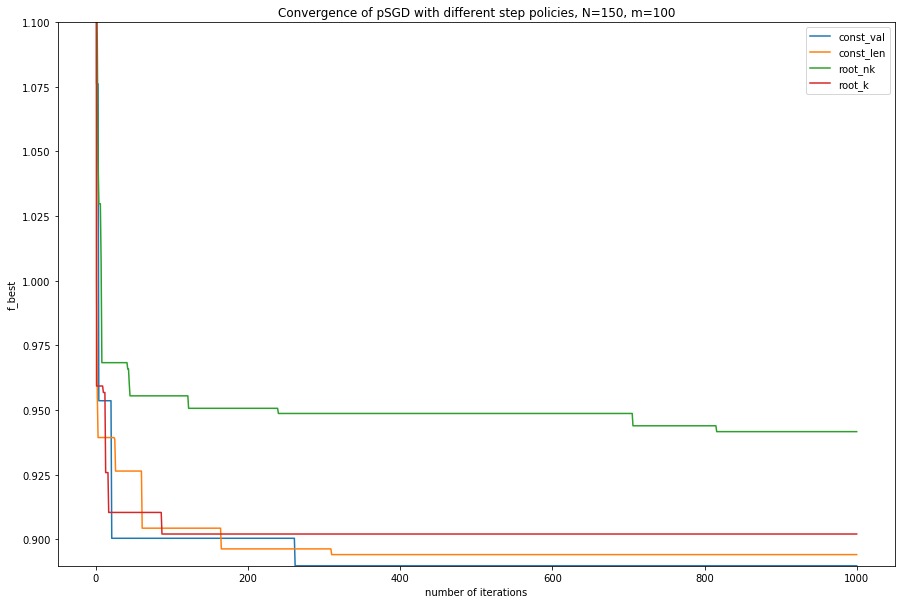

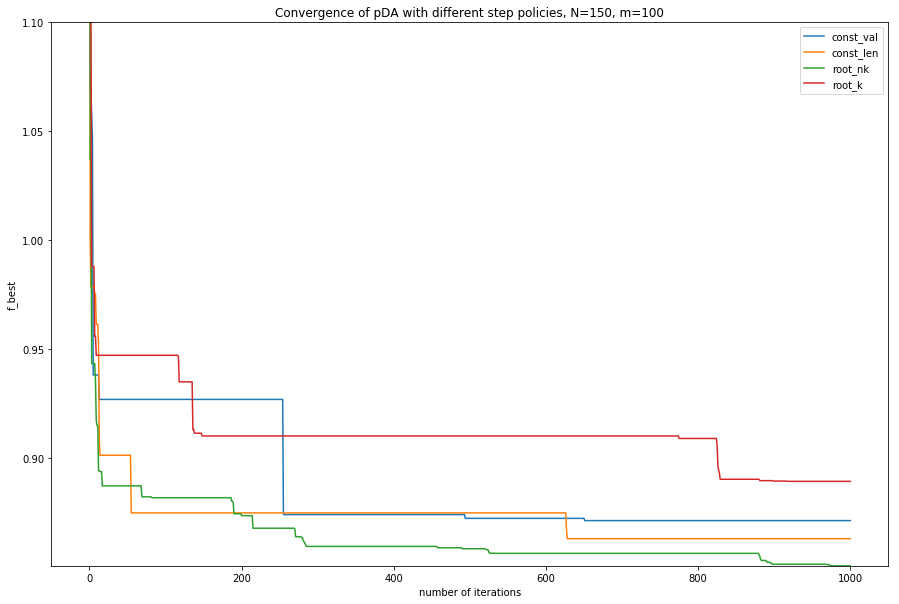

In [205]:
for m in [10, 50, 100]:
    A = np.random.normal(size=(N, m))
    plot_graphs()

#### Part (c). Is it true that one method results in much fewer non-zero entries than another?  Check it after 200, 400 and 1600 iterations.

Answer: judjing from the plot below it is true and dual averaging produces sighnificantly fewer nonzero entries than projected SGD.

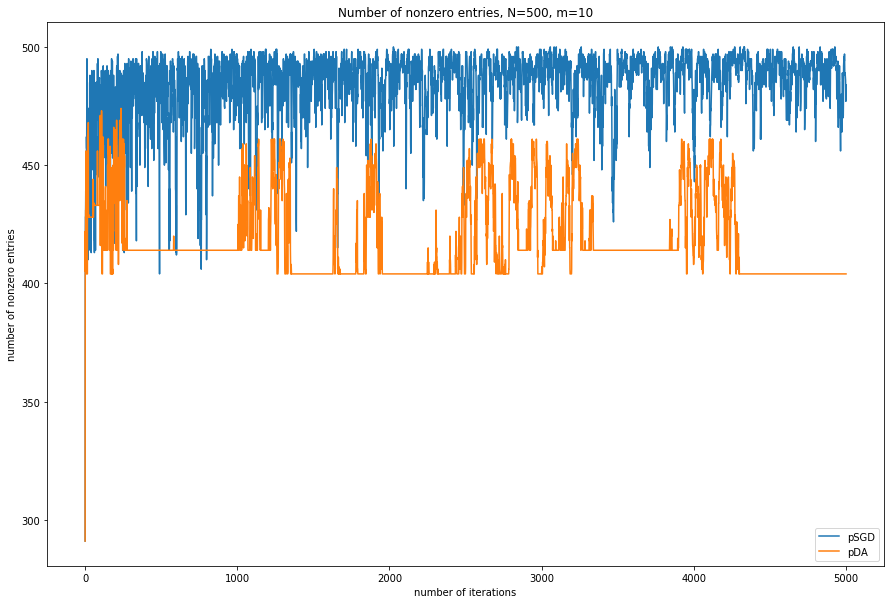

In [7]:
N = 500
m = 10
A = np.random.normal(size=(N,m))

x0 = np.random.normal(size=(m,))
plt.figure(figsize=(15,10))
for method in ['pSGD', 'pDA']:
    f_best, x_best, (x_k_all, _, _, _) = solve(
        x0, 
        method=method, 
        step_policy=SS_ROOT_K, 
        maxiter=5000
    )
    plt.plot([num_nonzero_entries(x_k) for x_k in x_k_all], label=method)
plt.xlabel("number of iterations")
plt.ylabel("number of nonzero entries")
plt.title(f"Number of nonzero entries, N={N}, m={m}")
plt.legend(loc='best')
plt.show()

### Problem 2

# Problem 3

#### part (a) - find dual problem

$$L(x, \lambda, \mu) = ||x - P^Tx||_2^2 - \lambda^T x + \mu (1^T x - 1)$$

$$\frac{dL}{dx} = 2AA^Tx-\lambda + \mu \mathbf{1} = 0 -> x = (AA^T)^{-1}(\lambda - \mu \mathbf{1}) / 2\text{, where }A=(I-P^T)$$

so then we can find $g(\lambda, \mu) = inf_x(L(x, \lambda, \mu) = int_x(L(x(\lambda, \mu), \lambda, \mu) = \dots = \frac{1}{4}(\lambda - \mu \mathbf{1})^T (AA^T)^{-1}(\lambda - \mu \mathbf{1}) - \frac{1}{2}\lambda^T (AA^T)^{-1} \lambda + \mu \lambda^T(AA^T)^{-1} \mathbf{1} - \frac{1}{2}\mu^2 1^T (AA^T)^{-1} \mathbf{1} - \mu$

so the dual is $\text{min}_{\lambda \ge 0, \mu} g(\lambda, \mu)$ for $g$ specified above

In [23]:
m = 10
avg_vertex_deg = 5
p = min(1, avg_vertex_deg / m)
P = scipy.sparse.random(m, m, density=p)
A = scipy.sparse.eye(m) - P.T

def f(x):
    return np.linalg.norm(A.dot(x)) ** 2

def compute_g_k(x):
    return 2 * A.dot(A.T.dot(x))

#### parts (b), (c)

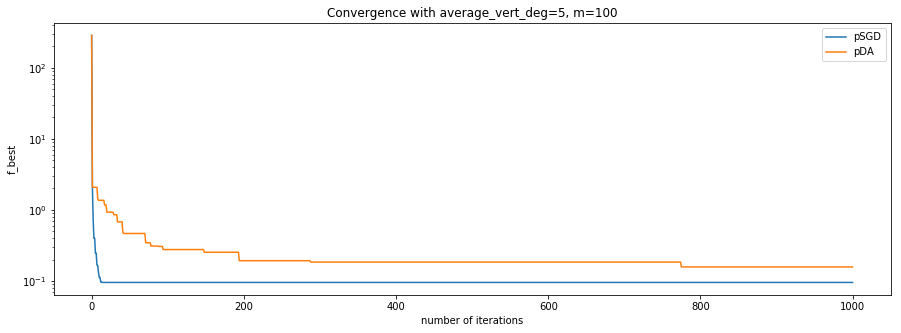

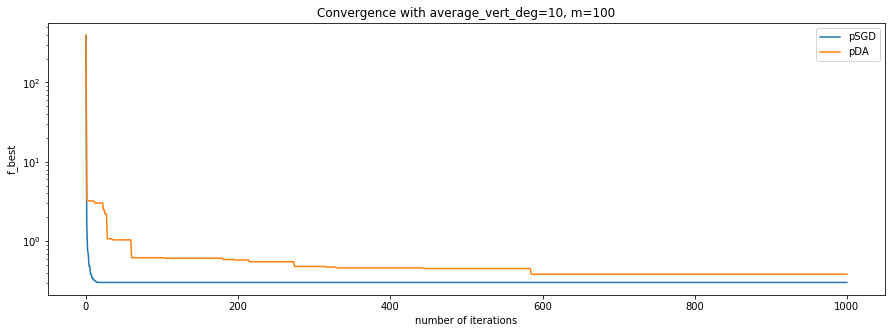

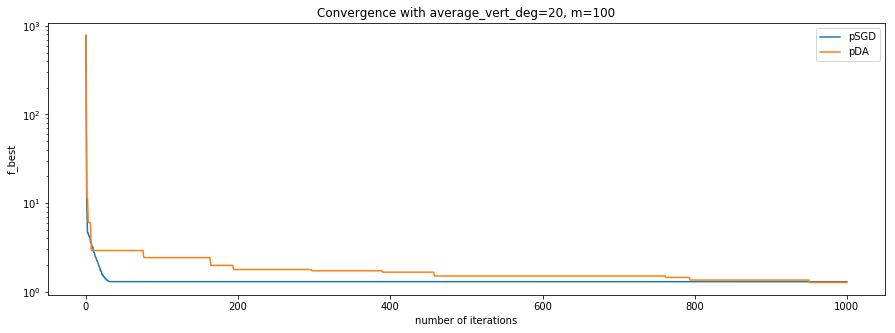

KeyboardInterrupt: 

<Figure size 1080x360 with 0 Axes>

In [36]:
def plot_graphs(maxiter=1000):
    x0 = np.random.normal(size=(m,))
    plt.figure(figsize=(15,5))
    for method in ['pSGD', 'pDA']:
        step_policy=SS_ROOT_NK
        if method == 'pDA':
            step_policy=SS_ROOT_K
        f_best, x_best, (x_k_all, g_k_all, f_all, f_best_all) = solve(
            x0, 
            method=method, 
            step_policy=step_policy, 
            maxiter=maxiter
        )
        plt.plot(f_best_all, label=method)
#     plt.ylim((0, 15))
    plt.yscale('log')
    plt.xlabel("number of iterations")
    plt.ylabel("f_best")
    plt.title(f"Convergence with average_vert_deg={avg_vertex_deg}, m={m}")
    plt.legend(loc='best')
    plt.show()

for m in [100, 1000, 10000, 100000]:
    for avg_vertex_deg in [5, 10, 20]:
        p = min(1, avg_vertex_deg / m)
        P = scipy.sparse.random(m, m, density=p)
        A = scipy.sparse.eye(m) - P.T
        plot_graphs()

In [ ]:
# have not enough time to calculate